In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from scipy.misc import imread, imresize
sys.path.append("tensorflow-vgg")
import vgg16
import pandas as pd
from pylab import rcParams
from os import listdir
import os
from sklearn.neighbors import KDTree


rcParams['figure.figsize'] = 8, 10

def ls_function(mypath):
    return [f for f in listdir(mypath) if not f == '.DS_Store']

def load_images_as_batch(paths):
    return np.vstack([imresize(imread(p), (224,224,3))[None,...] for p in paths])


#Get paths to images
path_to_images = "/media/data_cifs/nyu/img/"
all_paths = []
for l in tqdm(ls_function(path_to_images)):
    try:
        all_paths += ["{}/{}/{}".format(path_to_images, l, f) for f in ls_function("{}/{}".format(path_to_images, l))]
    except OSError as e:
        continue
        

all_paths = np.random.permutation(all_paths)

In [ ]:
#Generate Feature Vectors
device = "/gpu:2" #device to run on. Set to "/cpu:0" if your machine isn't equipped with a CUDA-capable GPU
os.environ["CUDA_VISIBLE_DEVICES"]=device.split(":")[-1][0] #Enfore that only the specified device is used

processed_paths = [] #List of image paths
processed_feature_vectors = [] #Feature vector for each path. In a real application this won't fit in memory. 
batch_size = 50 #Number of images to run at each step
#Maximum number of images in the "dataset". Performance will improve and things will slow down as this number goes up
num_images = 10000 

tf.reset_default_graph() #Clear the tensorflow graph
x = tf.placeholder(tf.float32, (None, 224, 224, 3), name="x") #Tensorflow placeholder variable
with tf.device(device):
    #build the model
    vgg = vgg16.Vgg16()
    vgg.build(x)
    sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
    #Run each batch of images through the model and generate the feature vectors
    for i in tqdm(range(0, num_images, batch_size)):
        batch = load_images_as_batch(all_paths[i:i+batch_size])
        feature_vectors = sess.run(vgg.fc7, feed_dict={x:batch})
        processed_paths += list(all_paths[i:i+batch_size])
        processed_feature_vectors += list(feature_vectors)

#Build the nearest neighbor tree of feature vectors
tree = KDTree(np.vstack(processed_feature_vectors))    

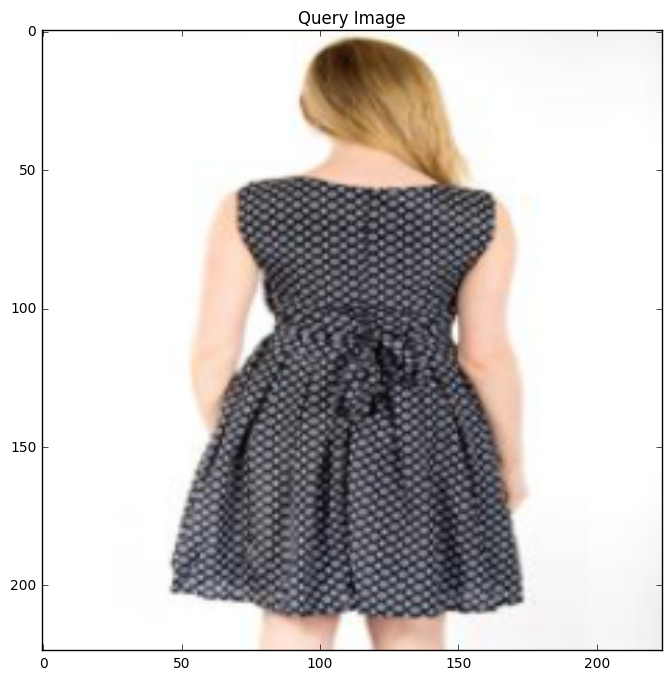

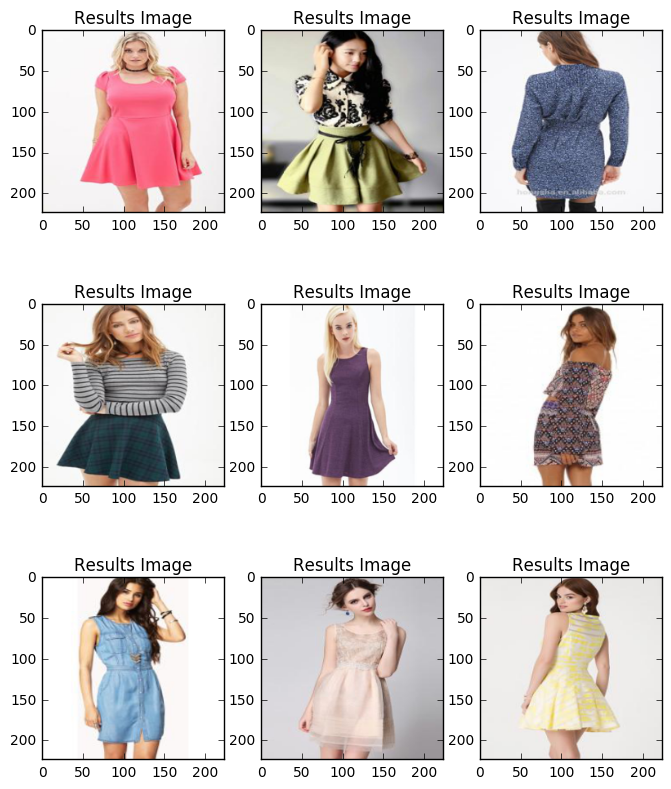

In [10]:
#Put the path to the query image here (the image that you would like to find similar images to)
image_path = '/media/data_cifs/nyu/img//Diamond_Print_Skater_Dress/img_00000002.jpg'

query_image = load_images_as_batch([image_path])
feature_vector = sess.run(vgg.fc7, feed_dict={x:query_image})
_, inds = tree.query(feature_vector, k=9) 

results_images = load_images_as_batch([processed_paths[ind] for ind in inds[0]])
plt.figure()
plt.title("Query Image")
plt.imshow(query_image[0])
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Results Image")
    plt.imshow(results_images[i])